In [2]:
!curl https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_Houses_dataset.csv > ../raw_data/ML_house.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  569k  100  569k    0     0   226k      0  0:00:02  0:00:02 --:--:--  226k


In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import FunctionTransformer

In [66]:
df = pd.read_csv('../raw_data/ML_house.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [67]:
df.shape

(1760, 85)

In [68]:
df.drop(columns = 'Id',inplace=True)

## Data preprocessing

In [69]:
# duplicates

#df.duplicated().sum()
df = df.drop_duplicates()
df.shape

(1460, 84)

In [70]:
# null 

(df.isnull().sum()/len(df)).sort_values(ascending=False).head(10)

WallMat         0.996575
PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

In [71]:
#numerical features

num_features = ['PoolQC','MiscFeature','Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageCond','GarageFinish','GarageQual','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1','MasVnrType']
null_imputer = SimpleImputer(strategy='constant',fill_value='None')
df[num_features] = null_imputer.fit_transform(df[num_features])

In [72]:
#categorical features 

cat_features = ['Electrical', 'MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional', 'SaleType']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

In [73]:
# ordinal features

features_ordinal = ['BsmtFullBath','BsmtHalfBath', 'GarageCars', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
ordinal_imputer = SimpleImputer(strategy='median')
df[features_ordinal] = ordinal_imputer.fit_transform(df[features_ordinal])

In [74]:
mean_imputer = SimpleImputer()
df['LotFrontage'] = mean_imputer.fit_transform(df[['LotFrontage']])

## feature scaling

In [75]:
# numerical features

num = df.select_dtypes(include=['int64','float64']).drop(columns='SalePrice').columns
scaler = RobustScaler()
df[num] = scaler.fit_transform(df[num])

In [76]:
# categorical features

df.LotShape.replace(to_replace = ['IR3', 'IR2', 'IR1', 'Reg'], value = [0, 1, 2, 3], inplace = True)
df.LandContour.replace(to_replace = ['Low', 'Bnk', 'HLS', 'Lvl'], value = [0, 1, 2, 3], inplace = True)
df.Utilities.replace(to_replace = ['NoSeWa', 'AllPub'], value = [0, 1], inplace = True)
df.LandSlope.replace(to_replace = ['Sev', 'Mod', 'Gtl'], value = [0, 1, 2], inplace = True)
df.ExterQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df.BsmtQual.replace(to_replace = ['None', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df.BsmtCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
df.BsmtExposure.replace(to_replace = ['None', 'No', 'Mn', 'Av', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
df.BsmtFinType1.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df.BsmtFinType2.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df.Electrical.replace(to_replace = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], value = [0, 1, 2, 3, 4], inplace = True)
df.KitchenQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df.Functional.replace(to_replace = ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df.FireplaceQu.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df.GarageFinish.replace(to_replace =  ['None', 'Unf', 'RFn', 'Fin'], value = [0, 1, 2, 3], inplace = True)
df.GarageQual.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df.GarageCond.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df.PavedDrive.replace(to_replace =  ['N', 'P', 'Y'], value = [0, 1, 2], inplace = True)
df.PoolQC.replace(to_replace =  ['None', 'Fa', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df.Fence.replace(to_replace =  ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], value = [0, 1, 2, 3, 4], inplace = True)

In [77]:
df = pd.get_dummies(df)
df.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.2,-0.265787,-0.254076,3,3,1,2,0.5,0.0,0.652174,...,0,0,0,1,0,0,0,0,1,0
1,-0.6,0.523686,0.030015,3,3,1,2,0.0,3.0,0.065217,...,0,0,0,1,0,0,0,0,1,0
2,0.2,-0.107893,0.437624,2,3,1,2,0.5,0.0,0.608696,...,0,0,0,1,0,0,0,0,1,0
3,0.4,-0.528945,0.017663,2,3,1,2,0.5,0.0,-1.260870,...,0,0,0,1,1,0,0,0,0,0
4,0.2,0.734213,1.181201,2,3,1,2,1.0,0.0,0.586957,...,0,0,0,1,0,0,0,0,1,0


## feature engineering

In [78]:
df.drop(columns = ['Pesos','RoofSurface'],inplace=True)

In [89]:
X = df.drop(columns=['SalePrice','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2'])
y = df['SalePrice']

In [90]:
model = LinearRegression()
score = cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error')

In [91]:
score.mean()

-34702.02565345445

In [92]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
feature_importance = permutation_importance(model,X,y)

In [94]:
df_im = pd.DataFrame(np.vstack((X.columns,feature_importance.importances_mean)).T)

In [95]:
df_im = df_im.rename(columns={0:'features',1:'score'})

In [96]:
len(X.columns)

220

In [97]:
hot_features = []
scores = []

for i in range(1,len(df_im)):
    im_features = list(df_im.head(i).features)
    X_ = X[im_features]
    score = cross_val_score(model,X_,y,cv=10)
    scores.append(score.mean())
    hot_features.append(i)

Text(0, 0.5, 'R2')

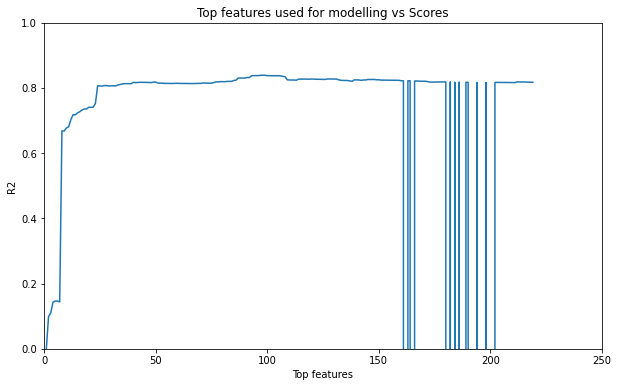

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(hot_features, scores)
plt.title('Top features used for modelling vs Scores')
plt.xlim([0,250])
plt.ylim([0,1])
plt.xlabel('Top features')
plt.ylabel('R2')